In [11]:
import pandas as pd
import seaborn as sns
from sodapy import Socrata
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv

dotenv_path = "/.env"
load_dotenv(dotenv_path)

opendata_token = os.getenv("opendata_token")
client = Socrata("data.cityofnewyork.us", opendata_token)

df_addy = pd.read_csv("nypd_precinct_addresses.csv")
df_addy.head()

,Unnamed: 0,Precinct,Address,Borough,State,ZIP,Latitude,Longitude,full_address
0,0,1st Precinct,16 Ericsson Place,Manhattan,NY,NaN,40.720602,-74.008348,"16 Ericsson Place, Manhattan, NY"
1,1,5th Precinct,19 Elizabeth Street,Manhattan,NY,NaN,40.716186,-73.997489,"19 Elizabeth Street, Manhattan, NY"
2,2,6th Precinct,233 West 10 Street,Manhattan,NY,NaN,40.734246,-74.005444,"233 West 10 Street, Manhattan, NY"
3,3,7th Precinct,19 1/2 Pitt Street,Manhattan,NY,NaN,40.716287,-73.983770,"19 1/2 Pitt Street, Manhattan, NY"
4,4,9th Precinct,321 East 5 Street,Manhattan,NY,NaN,43.148009,-77.594437,"321 East 5 Street, Manhattan, NY"


In [3]:
def api_call(index):
    lat = df_addy.loc[index, 'Latitude']
    lon = df_addy.loc[index, 'Longitude']
    results = client.get("erm2-nwe9", where=f"within_circle(location, {lat}, {lon}, 40)", complaint_type='Illegal Parking', limit=3000000)
    tmp_df = pd.DataFrame.from_records(results)
    if tmp_df.empty:
        print(df_addy.loc[index, 'Precinct'])
    return tmp_df


df = api_call(0)
df['precinct'] = df_addy.loc[0, 'Precinct']

for index, row in df_addy.iterrows():
    if index == 0:
        continue
    tmp = api_call(index)
    tmp['precinct'] = df_addy.loc[index, 'Precinct']

    df = pd.concat([df, tmp], ignore_index=True)

df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])
print(df.shape)
df.head()


9th Precinct
48th Precinct
50th Precinct
113th Precinct
121st Precinct
(13133, 36)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,facility_type,due_date,precinct,vehicle_type
0,58967049,2023-09-29 17:49:27,2023-09-29 18:14:42,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10013,135 HUDSON STREET,...,MOBILE,Unspecified,MANHATTAN,40.72071626640624,-74.00846336633435,"{'latitude': '40.72071626640624', 'longitude':...",NaN,NaN,1st Precinct,NaN
1,58948576,2023-09-28 16:05:19,2023-09-28 16:30:10,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10013,135 HUDSON STREET,...,MOBILE,Unspecified,MANHATTAN,40.72071626640624,-74.00846336633435,"{'latitude': '40.72071626640624', 'longitude':...",NaN,NaN,1st Precinct,NaN
2,58949790,2023-09-28 12:46:41,2023-09-28 13:22:09,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10013,135 HUDSON STREET,...,MOBILE,Unspecified,MANHATTAN,40.72071626640624,-74.00846336633435,"{'latitude': '40.72071626640624', 'longitude':...",NaN,NaN,1st Precinct,NaN
3,58777574,2023-09-11 16:34:50,2023-09-11 17:17:11,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10013,135 HUDSON STREET,...,MOBILE,Unspecified,MANHATTAN,40.72071626640624,-74.00846336633435,"{'latitude': '40.72071626640624', 'longitude':...",NaN,NaN,1st Precinct,NaN
4,58781718,2023-09-11 14:41:34,2023-09-11 15:02:27,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10013,141 HUDSON STREET,...,MOBILE,Unspecified,MANHATTAN,40.72093036050311,-74.00842371009091,"{'latitude': '40.72093036050311', 'longitude':...",NaN,NaN,1st Precinct,NaN


In [4]:
df = df[df['created_date'] > '2013-06-30']
df = df[df['closed_date'] < '2023-07-01']
df.shape

(8333, 36)

In [5]:
df.groupby('resolution_description').unique_key.count().sort_values(ascending=False)

resolution_description
The Police Department responded to the complaint and determined that police action was not necessary.                                                                                        5000
The Police Department responded to the complaint and took action to fix the condition.                                                                                                       1393
The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.                                                      1280
The Police Department responded and upon arrival those responsible for the condition were gone.                                                                                               264
The Police Department issued a summons in response to the complaint.                                                                                                                          151
The Pol

In [6]:
def get_fiscal_year(date):
    if date.month >= 7:
        return date.year + 1
    else:
        return date.year

df['fiscal_year'] = df['closed_date'].apply(get_fiscal_year)
df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,park_facility_name,park_borough,latitude,longitude,location,facility_type,due_date,precinct,vehicle_type,fiscal_year
14,57977372,2023-06-22 19:32:10,2023-06-22 20:03:24,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,10013,135 HUDSON STREET,...,Unspecified,MANHATTAN,40.72071626640624,-74.00846336633435,"{'latitude': '40.72071626640624', 'longitude':...",NaN,NaN,1st Precinct,NaN,2023
15,57951677,2023-06-20 14:09:27,2023-06-20 14:18:07,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10013,135 HUDSON STREET,...,Unspecified,MANHATTAN,40.72071626640624,-74.00846336633435,"{'latitude': '40.72071626640624', 'longitude':...",NaN,NaN,1st Precinct,NaN,2023
16,57910750,2023-06-15 11:54:55,2023-06-15 12:10:24,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10013,135 HUDSON STREET,...,Unspecified,MANHATTAN,40.72071626640624,-74.00846336633435,"{'latitude': '40.72071626640624', 'longitude':...",NaN,NaN,1st Precinct,NaN,2023
17,57897080,2023-06-14 15:52:14,2023-06-14 16:30:05,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,10013,135 HUDSON STREET,...,Unspecified,MANHATTAN,40.72071626640624,-74.00846336633435,"{'latitude': '40.72071626640624', 'longitude':...",NaN,NaN,1st Precinct,NaN,2023
18,57789872,2023-06-02 17:33:05,2023-06-02 17:59:54,NYPD,New York City Police Department,Illegal Parking,Blocked Hydrant,Street/Sidewalk,10013,135 HUDSON STREET,...,Unspecified,MANHATTAN,40.72071626640624,-74.00846336633435,"{'latitude': '40.72071626640624', 'longitude':...",NaN,NaN,1st Precinct,NaN,2023


In [19]:
grouped_total = df.groupby('fiscal_year').unique_key.count().reset_index()
tmp = df[df['resolution_description']=="The Police Department issued a summons in response to the complaint."]
grouped_matched = tmp.groupby('fiscal_year').unique_key.count().reset_index()
grouped = pd.merge(grouped_total, grouped_matched, on='fiscal_year')
print(100*(grouped['unique_key_y'].sum()/grouped['unique_key_x'].sum()))
grouped = grouped.rename(columns={'unique_key_x': 'illegal parking complaints', 'unique_key_y': 'ticket issued, per NYPD'})
grouped['fiscal_year'] = grouped['fiscal_year'].astype(str) + '-06-30'

grouped.to_csv('percint_summons_chart.csv', index=False)

1.812072482899316


In [8]:
df['resolution_time'] = df['closed_date'] - df['created_date']
print(df['resolution_time'].mean())

0 days 00:55:33.876515060


In [ ]:
df.to_csv('311_precinct_parking_40m.csv', index=False)

In [20]:
df_summons = df[df['resolution_description']=="The Police Department issued a summons in response to the complaint."]
print(df_summons.shape)

(151, 38)


In [21]:
grouped_total = grouped_total.rename(columns={'unique_key': 'total_311_complaints'})
df_summons = df_summons.groupby('fiscal_year').unique_key.count().reset_index()
df_summons = df_summons.rename(columns={'unique_key': 'num_summonses'})

df_viz = pd.merge(grouped_total, df_summons, on='fiscal_year')
df_viz.head(11)

,fiscal_year,total_311_complaints,num_summonses
0,2014,39,2
1,2015,56,4
2,2016,82,1
3,2017,137,1
4,2018,108,5
5,2019,253,14
6,2020,688,6
7,2021,991,21
8,2022,1517,32
9,2023,4462,65


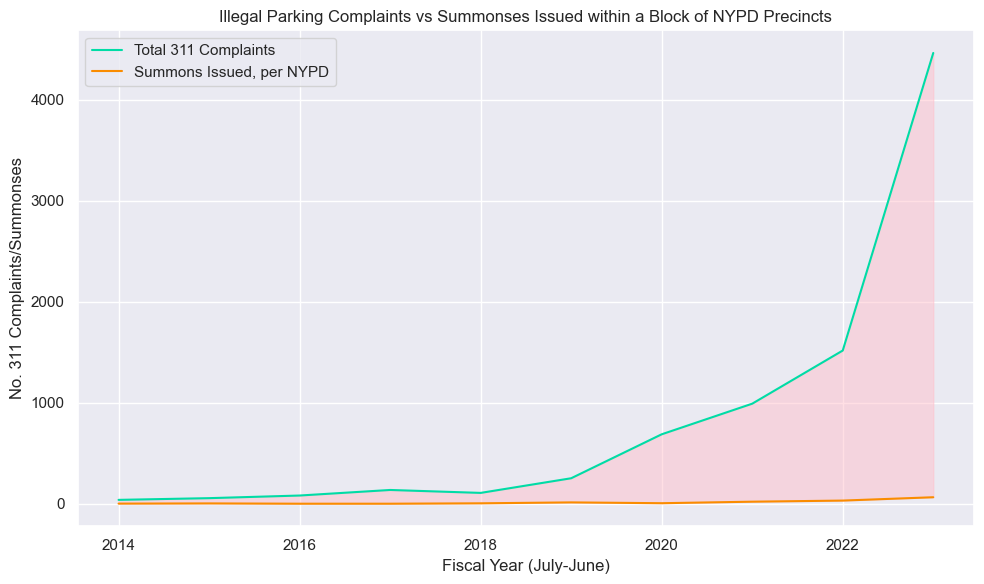

In [24]:
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_viz, x='fiscal_year', y='total_311_complaints', label='Total 311 Complaints', color='#00dca6')
sns.lineplot(data=df_viz, x='fiscal_year', y='num_summonses', label='Summons Issued, per NYPD', color='#fa8c00')
plt.fill_between(df_viz['fiscal_year'], df_viz['total_311_complaints'], df_viz['num_summonses'], color='pink', alpha=0.5)

plt.title('Illegal Parking Complaints vs Summonses Issued within a Block of NYPD Precincts')
plt.xlabel('Fiscal Year (July-June)')
plt.ylabel('No. 311 Complaints/Summonses')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()